In [4]:
import pandas as pd
import numpy as np
import tushare as ts
import os 
from tqdm import tqdm
import glob
from datetime import datetime 

In [5]:
import numpy as np
import pandas as pd
from numpy import abs
from numpy import log
from numpy import sign
from scipy.stats import rankdata

def ts_sum(df, window=10):
    return df.rolling(window).sum()

def sma(df, window=10):
    return df.rolling(window).mean()

def stddev(df, window=10):
    return df.rolling(window).std()

def correlation(x, y, window=10):
    return x.rolling(window).corr(y)

def covariance(x, y, window=10):
    return x.rolling(window).cov(y)

def rolling_rank(na):
    return rankdata(na)[-1]

def ts_rank(df, window=10):
    return df.rolling(window).apply(rolling_rank)

def rolling_prod(na):
    return np.prod(na)

def product(df, window=10):
    return df.rolling(window).apply(rolling_prod)

def ts_min(df, window=10):
    return df.rolling(window).min()

def ts_max(df, window=10):
    return df.rolling(window).max()

def delta(df, period=1):
    return df.diff(period)

def delay(df, period=1):
    return df.shift(period)

def rank(df):
    return df.rank(axis=1, pct=True)
#     return df.rank(pct=True)

def scale(df, k=1):
    return df.mul(k).div(np.abs(df).sum())

def ts_argmax(df, window=10):
    return df.rolling(window).apply(np.argmax) + 1 

def ts_argmin(df, window=10):
    return df.rolling(window).apply(np.argmin) + 1

def decay_linear(df, period=10):
    if df.isnull().values.any():
        df.fillna(method='ffill', inplace=True)
        df.fillna(method='bfill', inplace=True)
        df.fillna(value=0, inplace=True)
    na_lwma = np.zeros_like(df)
    na_lwma[:period, :] = df.iloc[:period, :] 
    na_series = df.values
    divisor = period * (period + 1) / 2
    y = (np.arange(period) + 1) * 1.0 / divisor
    for row in range(period - 1, df.shape[0]):
        x = na_series[row - period + 1: row + 1, :]
        na_lwma[row, :] = (np.dot(x.T, y))
    return pd.DataFrame(na_lwma, index=df.index, columns=df.columns)  



In [6]:
import pandas as pd
price_PD_total = pd.read_csv('../weichy7/price_PD.csv', dtype = {'trade_date': 'str'})
price_PD_total = price_PD_total.drop_duplicates(['ts_code', 'trade_date']).sort_values(['ts_code', 'trade_date']).reset_index(drop=True)


In [7]:
import tushare as ts
ts.set_token('0948b6427e46bb1bc7fa60b52df96ab0080b9d4ff80209a5fee99277')
pro = ts.pro_api()
all_stock = pro.stock_basic()

In [8]:
all_stock = all_stock[['ts_code','name','market']]
price_PD_total = pd.merge(price_PD_total,all_stock,how='left',on='ts_code')
price_PD_total = price_PD_total[['ts_code', 'name','market', 'trade_date', 'open', 'high', 'low',
       'close', 'pre_close','change', 'pct_chg', 'vol', 'amount']]


In [9]:
indus = pd.read_excel('./data/a_stock_industry.xlsx')
indus = indus[['windcode','申万行业L1','申万行业L2','申万行业L3']]
indus.columns = ['ts_code','indus1','indus2','indus3']
indus.head()

,ts_code,indus1,indus2,indus3
0,000001.SZ,银行,银行Ⅱ,银行Ⅲ
1,000002.SZ,房地产,房地产开发Ⅱ,房地产开发Ⅲ
2,000004.SZ,计算机,计算机应用,IT服务
3,000005.SZ,公用事业,环保工程及服务Ⅱ,环保工程及服务Ⅲ
4,000006.SZ,房地产,房地产开发Ⅱ,房地产开发Ⅲ


In [10]:
price_PD_total = pd.merge(price_PD_total,indus,how='left',on='ts_code')

In [11]:
price_PD_total = price_PD_total[price_PD_total.market.isin(['主板','中小板','创业板'])]
price_PD_total = price_PD_total[~price_PD_total.name.str.contains('ST')].reset_index(drop=True)

In [12]:
price_PD_total['ret1'] = price_PD_total.groupby('ts_code').close.shift(-1)/price_PD_total.groupby('ts_code').close.shift(0) 


In [13]:
price_PD_total.head()

,ts_code,name,market,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,indus1,indus2,indus3,ret1
0,000001.SZ,平安银行,主板,20150105,10.1514,10.3355,9.9038,10.1704,10.0562,0.1142,1.1356,2860436.43,4.565388e+06,银行,银行Ⅱ,银行Ⅲ,0.985025
1,000001.SZ,平安银行,主板,20150106,10.0625,10.4053,9.8720,10.0181,10.1704,-0.1523,-1.4975,2166421.40,3.453446e+06,银行,银行Ⅱ,银行Ⅲ,0.980984
2,000001.SZ,平安银行,主板,20150107,9.8784,10.0498,9.7133,9.8276,10.0181,-0.1905,-1.9016,1700120.67,2.634796e+06,银行,银行Ⅱ,银行Ⅲ,0.966411
3,000001.SZ,平安银行,主板,20150108,9.8403,9.8847,9.4594,9.4975,9.8276,-0.3301,-3.3589,1407714.21,2.128003e+06,银行,银行Ⅱ,银行Ⅲ,1.008023
4,000001.SZ,平安银行,主板,20150109,9.4594,10.0752,9.3388,9.5737,9.4975,0.0762,0.8023,2508500.23,3.835378e+06,银行,银行Ⅱ,银行Ⅲ,0.979444


In [15]:
price_PD_wfq = pd.read_csv('../weichy7/price_PD_2015至今_未复权.csv')
price_PD_wfq.trade_date = price_PD_wfq.trade_date.astype('str')
price_PD_wfq = price_PD_wfq.drop_duplicates(['ts_code', 'trade_date']).sort_values(['ts_code', 'trade_date']).reset_index(drop=True)
price_PD_wfq['vwap'] = price_PD_wfq.amount/price_PD_wfq.vol
price_PD_wfq = price_PD_wfq[price_PD_wfq.ts_code.isin(price_PD_total.ts_code.unique())]



In [16]:
daily_info = {}
daily_info['open'] = price_PD_wfq.pivot('trade_date', 'ts_code', 'open')
daily_info['close'] = price_PD_wfq.pivot('trade_date', 'ts_code', 'close')
daily_info['high']  = price_PD_wfq.pivot('trade_date', 'ts_code', 'high')
daily_info['low']  = price_PD_wfq.pivot('trade_date', 'ts_code', 'low')
daily_info['vol']  = price_PD_wfq.pivot('trade_date', 'ts_code', 'vol')
daily_info['amount']  = price_PD_wfq.pivot('trade_date', 'ts_code', 'amount')
daily_info['vwap']  = (daily_info['amount']*1000)/(daily_info['vol']*100+1) 



In [22]:
def fun(x):
    if x < 0.2: return 1
    elif 0.2 <= x < 0.4: return 2
    elif 0.4 <= x < 0.6: return 3
    elif 0.6 <= x < 0.8: return 4
    elif 0.8 <= x <= 1: return 5
    else: return np.nan
    
    

In [18]:
class AlphaLib(object):
    def __init__(self, daily_info):
        self.open = daily_info['open']
        self.high = daily_info['high']
        self.low = daily_info['low']
        self.close = daily_info['close']
        self.vwap = daily_info['vwap'] 
        self.amount = daily_info['amount']
        
    def calcu_alpha(self):
        alpha_dict={}
        alpha_dict['alpha02']=sma(self.amount,5).div(self.amount.sum(1),axis=0)
        return alpha_dict
        

In [26]:
tmp_class = AlphaLib(daily_info)
alpha_dict = tmp_class.calcu_alpha()

In [27]:
alpha = alpha_dict['alpha02'].unstack().reset_index().rename(columns={0:'factor'})
# alpha = alpha.dropna()


In [28]:
alpha = pd.merge(alpha, price_PD_total[['trade_date', \
        'ts_code','ret1','indus1']], how='left', on=['trade_date', 'ts_code'])

In [29]:
alpha['factor_rank'] = alpha.groupby(['trade_date','indus1']).factor.rank(pct=True,method='dense')


In [30]:
alpha

,ts_code,trade_date,factor,ret1,indus1,factor_rank
0,000001.SZ,20150105,NaN,0.985025,银行,NaN
1,000001.SZ,20150106,NaN,0.980984,银行,NaN
2,000001.SZ,20150107,NaN,0.966411,银行,NaN
3,000001.SZ,20150108,NaN,1.008023,银行,NaN
4,000001.SZ,20150109,0.005132,0.979444,银行,0.375000
...,...,...,...,...,...,...
7547875,605599.SH,20220908,0.000014,0.980431,轻工制造,0.057325
7547876,605599.SH,20220909,0.000029,0.996008,轻工制造,0.273885
7547877,605599.SH,20220913,0.000036,0.986974,轻工制造,0.324841
7547878,605599.SH,20220914,0.000042,0.983756,轻工制造,0.350318


In [31]:
alpha['factor_rank_bin'] = alpha.factor_rank.apply(fun)

In [33]:
alpha.factor_rank_bin.value_counts()

5.0    1191328
2.0    1159742
4.0    1159742
3.0    1159307
1.0    1128724
Name: factor_rank_bin, dtype: int64

<AxesSubplot:xlabel='trade_date'>

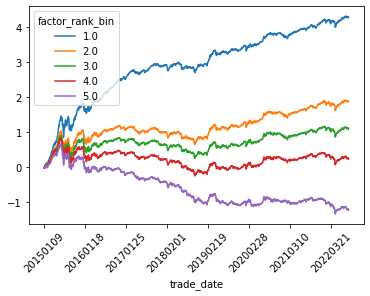

In [36]:
(alpha[alpha.trade_date > '20150101'].groupby(['factor_rank_bin', \
        'trade_date']).ret1.mean()-1).unstack().T.cumsum().plot(rot=45)

<AxesSubplot:xlabel='trade_date'>

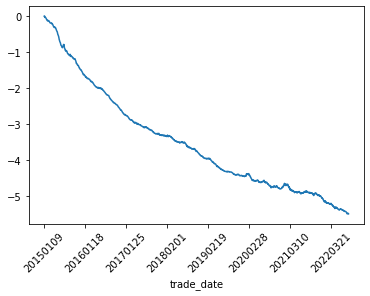

In [41]:
##计算做多做空收益
##做多factor最大的一组，做空factor最小的一组

long_ret = (alpha[(alpha.factor_rank_bin == 5)].groupby('trade_date').ret1.mean()-1).cumsum()
short_ret = (alpha[(alpha.factor_rank_bin == 1)].groupby('trade_date').ret1.mean()-1).cumsum()
(long_ret - short_ret).plot(rot=45)

In [46]:
ret_PD = (alpha.groupby(['factor_rank_bin', 'trade_date']).ret1.mean()-1.0015 ).unstack().T

if ret_PD[1.0].mean()>ret_PD[5.0].mean():
    ret_PD['diff'] = ret_PD[1.0] - ret_PD[5.0]
else:
    ret_PD['diff'] = ret_PD[5.0] - ret_PD[1.0]


In [47]:
def cal_sell_turnover(tmp):
    stock = pd.DataFrame(tmp.groupby('trade_date').apply(lambda x: set(x.ts_code))).rename(columns={0:'stock_list'})
    stock['stock_list_shift1'] = stock.stock_list.shift(1)
    stock = stock.dropna()
    freq = []
    for i in range(len(stock)):
        freq.append(1 - len(stock.iloc[i]['stock_list'] & stock.iloc[i]['stock_list_shift1'])/len(stock.iloc[i]['stock_list']))
    stock['freq'] = freq
    return stock['freq'].mean()

def max_dd(returns):
    """Assumes returns is a pandas Series"""
    r = returns.cumsum()+1
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min()
    end = returns.index[dd.argmin()]
    start = returns.index[r.loc[:end].argmax()]
    return mdd, start, end


def max_dd_month(ret_PD):
    ret2_month = ret_PD.reset_index()
    ret2_month['month'] = [str(xx)[:6] for xx in ret2_month['trade_date']]    
    ret2_month = ret2_month.groupby('month')['ret'].sum()
    ret2_month = ret2_month.sort_values()
    return [ret2_month.head(1).values[0],ret2_month.head(1).index[0],\
            (ret2_month>0).sum()/len(ret2_month),ret2_month[ret2_month>=0].mean(),\
            ret2_month[ret2_month<0].mean()]

 

def calc_pfmc(ret_PD):
    performance = []
    for i in [1,2,3,4,5,'diff']:
        returnlist = ret_PD[i]
        ret_year = (returnlist.mean()-0)*252
        ret_sharpe = (returnlist.mean()-0)/returnlist.std()*(252**0.5)
        max_draw, start, end = max_dd(returnlist)
        winratio = (returnlist>0).sum()/len(returnlist)
        std = returnlist.std()
        performance.append([i,ret_year,ret_sharpe,std,winratio,max_draw])
    performance = pd.DataFrame(performance,columns = ['group_name','return','sharpe',\
                    'std','winratio','mdd'])
    return performance

calc_pfmc(ret_PD)

,group_name,return,sharpe,std,winratio,mdd
0,1,0.202033,0.667391,0.019070,0.570582,-0.276797
1,2,-0.124478,-0.397390,0.019732,0.523707,-1.023917
2,3,-0.230663,-0.736072,0.019740,0.507004,-1.451768
3,4,-0.346631,-1.100037,0.019850,0.496228,-1.942496
4,5,-0.544555,-1.727453,0.019858,0.471983,-2.993987
5,diff,0.746587,6.121639,0.007683,0.681034,-0.047650


In [58]:
ICvalue = alpha.groupby(['trade_date'])[['factor','ret1']].corr()['factor'].reset_index()
ICvalue = ICvalue[ICvalue.level_1=='ret1']
ICvalue = ICvalue[['trade_date','factor']].set_index('trade_date')

<AxesSubplot:xlabel='trade_date'>

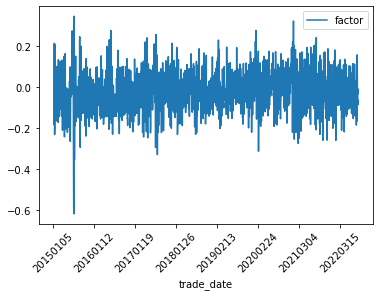

In [59]:
ICvalue.plot(rot=45)

In [61]:
ICvalue.mean()/ICvalue.std()

factor   -0.231962
dtype: float64